# Data filtering
Data filtering from behavior interrupting acuity tests (following the stripes):
1. Rearing
2. Scratching
3. Moving around

In [1]:
# data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate

%matplotlib inline
sns.set(color_codes=True)

dfPos = {}
dfOri = {}
df    = {}

sum_raw = 0
sum_fil1 = 0
sum_fil2 = 0
sum_fil3 = 0

hyperparam = { 'BPFlimit' : 0.5 ,
               'LPFlimit' : 0.13,
               'MOVElimit': 0.02,}

index = {'X', 'Y', 'Z'}

fnameClean = [
    'VRAcuityExp_2017-07-13_14-39-17_VR-4A_NIC_clean.h5',
    'VRAcuityExp_2017-07-13_15-05-16_VR-2B_NIC_clean.h5',
    'VRAcuityExp_2017-07-13_15-19-09_VR-2A_EDU_clean.h5',
    'VRAcuityExp_2017-07-13_15-38-34_VR-1A_NIC_clean.h5',
    'VRAcuityExp_2017-07-13_15-53-40_VR-1B_NIC_clean.h5',
    'VRAcuityExp_2017-07-13_16-11-46_VR-3A_NIC_clean.h5',
    'VRAcuityExp_2017-07-13_16-27-08_VR-3A_NIC_clean.h5',
    'VRAcuityExp_2017-07-13_17-09-07_VR-5A_NIC_clean.h5', ]

path = '../datasets/'

for i, x in enumerate(fnameClean):
    dfPos[i] = pd.read_hdf(path+fnameClean[i], 'Position')
    dfOri[i] = pd.read_hdf(path+fnameClean[i], 'Orientation')    
    sum_raw += len(dfPos[i])


## Rearing removal
Removal based on Y axis postion limit - low pass filter

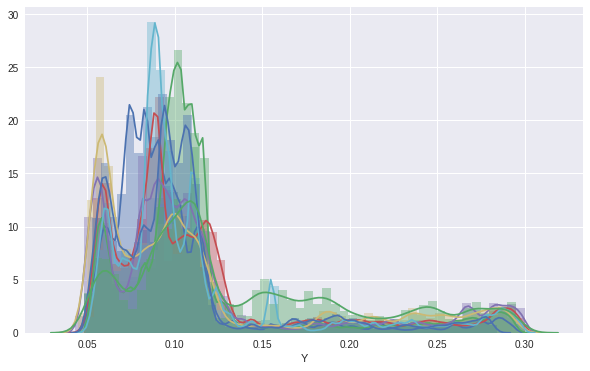

In [2]:
# data visutalization of all datasets before low pass filtering
fig = plt.figure(figsize=(10,6))
for i, x in enumerate(fnameClean):
    sns.distplot(dfPos[i].Y)

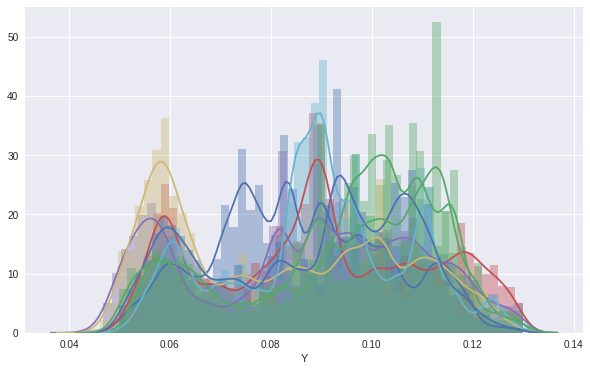

In [3]:
# removal of rearing positions

for i, x in enumerate(fnameClean):
    dfPos[i] = dfPos[i][dfPos[i]['Y'] < hyperparam['LPFlimit']]
    
# post filter vis
fig = plt.figure(figsize=(10,6))
for i, x in enumerate(fnameClean):
    sns.distplot(dfPos[i].Y)
    sum_fil1 += len(dfPos[i])

## Scratching and cleaning removal
Removal based on Y axis orientation limit - band pass filter

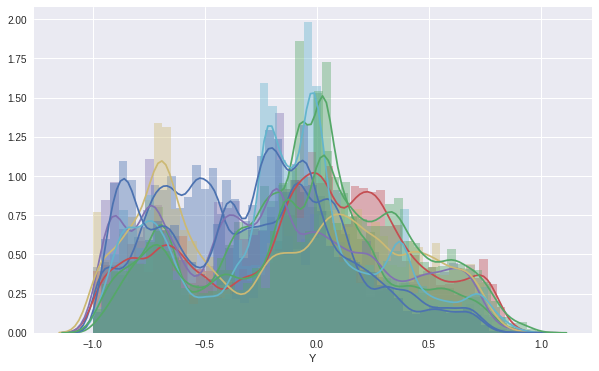

In [4]:
# data visutalization of all datasets before lband pass filtering
fig = plt.figure(figsize=(10,6))
for i, x in enumerate(fnameClean):
    sns.distplot(dfOri[i].Y)

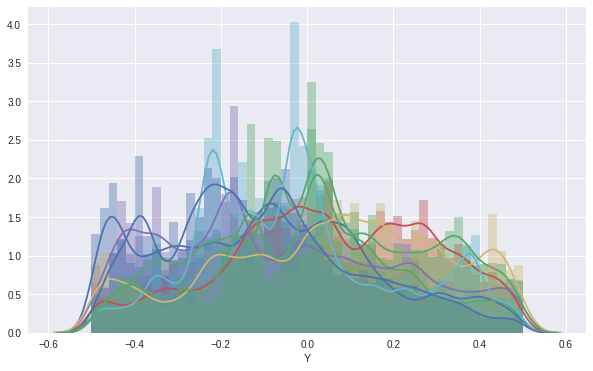

In [5]:
# "scratching" removal
for i, x in enumerate(fnameClean):
    dfOri[i] = dfOri[i][dfOri[i]['Y'] < hyperparam['BPFlimit']]
    dfOri[i] = dfOri[i][dfOri[i]['Y'] >-hyperparam['BPFlimit']]
    
# post filter vis
fig = plt.figure(figsize=(10,6))
for i, x in enumerate(fnameClean):
    sns.distplot(dfOri[i].Y)
    sum_fil2 += len(dfOri[i])


## Rapid movement removal
Removal based on speed of changes in the position of the animal - low pass filter of diagonal velocity.

To be decided: based on which/both data changes speed remove it

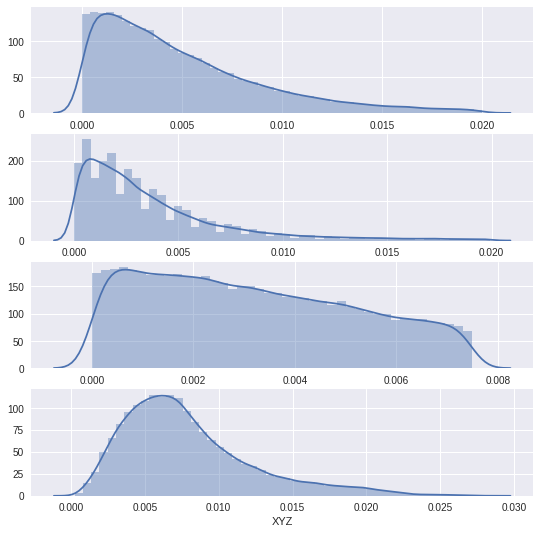

In [6]:
# Visualization for one experiment
# extraction of speed of positon changes
dfV = dfPos[1].diff()
dfV.Frame = dfPos[1].Frame.dropna()

# calculating velocity in all axes
dfV['X'] = dfV.apply(lambda row: np.absolute(row.X) / row.Time, axis=1)
dfV['Y'] = dfV.apply(lambda row: np.absolute(row.Y) / row.Time, axis=1)
dfV['Z'] = dfV.apply(lambda row: np.absolute(row.Z) / row.Time, axis=1)
dfV['XYZ'] = dfV.apply(lambda row: np.sqrt(row.X**2 + row.Y**2 + row.Z**2), axis=1) # diagonal velocity

for k in index:
    dfV = dfV[dfV[k] < hyperparam['MOVElimit']]

dfV = dfV[dfV[k] < 0.0075]
    
# velocity distribution in all axes
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

sns.distplot(dfV.X, ax=ax1)
sns.distplot(dfV.Y, ax=ax2)
sns.distplot(dfV.Z, ax=ax3)
sns.distplot(dfV.XYZ, ax=ax4)

In [7]:
dfV = {}

for i, x in enumerate(fnameClean):
    # extraction of positon and time changes
    dfV[i] = dfPos[i].diff()
    dfV[i].Frame = dfPos[i].Frame
    dfV[i].dropna(inplace=True)

    # calculating velocity in all axes
    dfV[i]['X']   = dfV[i].apply(lambda row: np.absolute(row.X) / row.Time, axis=1)
    dfV[i]['Y']   = dfV[i].apply(lambda row: np.absolute(row.Y) / row.Time, axis=1)
    dfV[i]['Z']   = dfV[i].apply(lambda row: np.absolute(row.Z) / row.Time, axis=1)
    dfV[i]['XYZ'] = dfV[i].apply(lambda row: np.sqrt(row.X**2 + row.Y**2 + row.Z**2), axis=1) # diagonal velocity

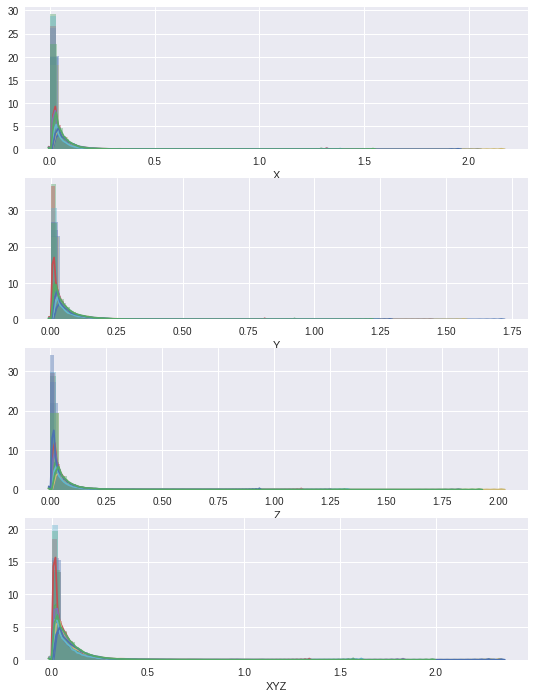

In [8]:
# pre-filtered distribution of velocity
fig = plt.figure(figsize=(9,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
#print(dfPos[0])
#print(dfV[0])

for i, x in enumerate(fnameClean):
    #print(dfV[i])
    sns.distplot(dfV[i].X  , ax=ax1)
    sns.distplot(dfV[i].Y  , ax=ax2)
    sns.distplot(dfV[i].Z  , ax=ax3)
    sns.distplot(dfV[i].XYZ, ax=ax4)
    

In [9]:
# filerting too big changes
for i, x in enumerate(fnameClean):
    dfV[i] = dfV[i][dfV[i]['XYZ'] < hyperparam['MOVElimit']]
    for k in index:
        dfV[i] = dfV[i][dfV[i][k] < hyperparam['MOVElimit']]
    

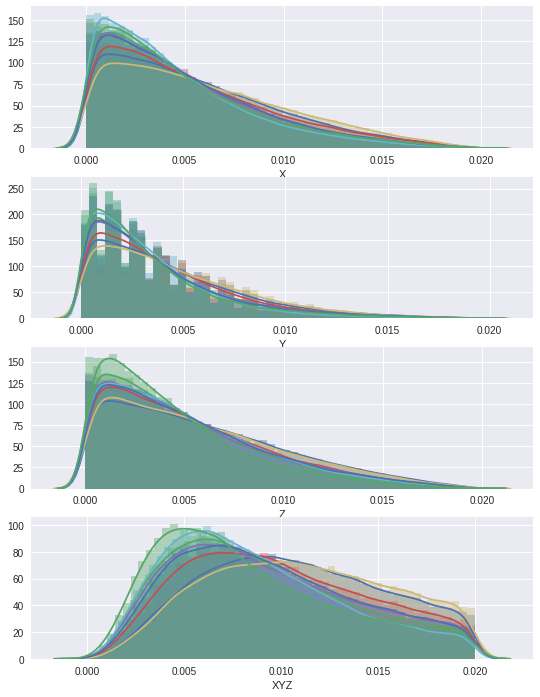

In [10]:
# filtered distribution of velocity
fig = plt.figure(figsize=(9,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

for i, x in enumerate(fnameClean):
    sns.distplot(dfV[i].X  , ax=ax1)
    sns.distplot(dfV[i].Y  , ax=ax2)
    sns.distplot(dfV[i].Z  , ax=ax3)
    sns.distplot(dfV[i].XYZ, ax=ax4)
    sum_fil3 += len(dfV[i])


## Merging the datasets
Datasets merged - extraction of only good experiments frames.
After deleting invalid frames of events - merging and visutalization of final data distributions

In [11]:
for i, x in enumerate(fnameClean):
    #dropping not needed columns form dfV
    #dfV[i].drop({'X','Y','Z','Time'}, axis=1, inplace=True)
    
    #merging based on Frames allignment
    df[i] = pd.merge( pd.merge(dfPos[i], dfOri[i], on='Frame', suffixes=('_Pos', '_Ori')), dfV[i], on='Frame')
    

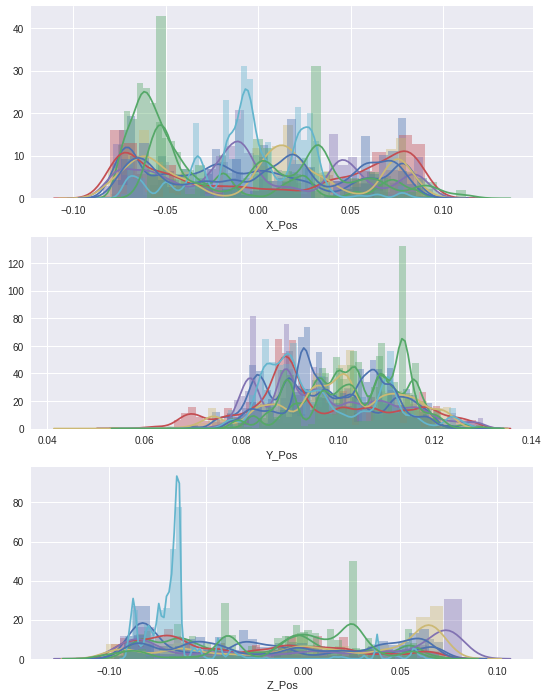

In [12]:
# Univariat positions X,Y,Z of all experiments after data removal
fig = plt.figure(figsize=(9,12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
    
for i, x in enumerate(fnameClean):
    sns.distplot(df[i].X_Pos, ax=ax1)
    sns.distplot(df[i].Y_Pos, ax=ax2)
    sns.distplot(df[i].Z_Pos, ax=ax3)

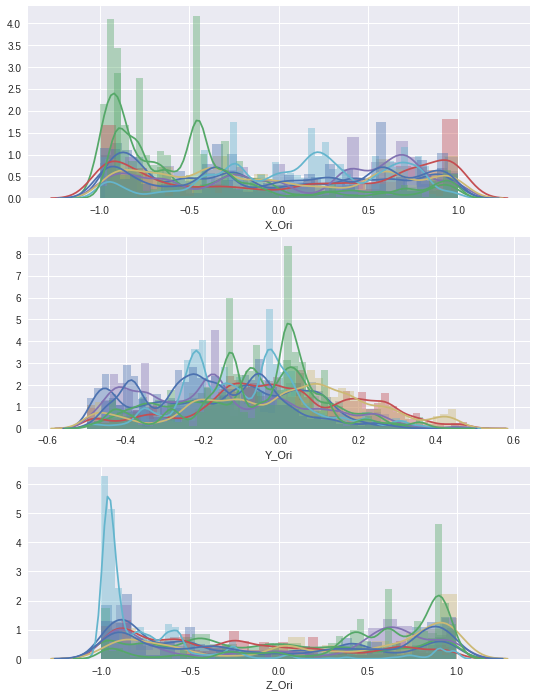

In [13]:
# Univariat orientation X,Y,Z of all experiments
fig = plt.figure(figsize=(9,12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
    
for i, x in enumerate(fnameClean):
    sns.distplot(df[i].X_Ori, ax=ax1)
    sns.distplot(df[i].Y_Ori, ax=ax2)
    sns.distplot(df[i].Z_Ori, ax=ax3)

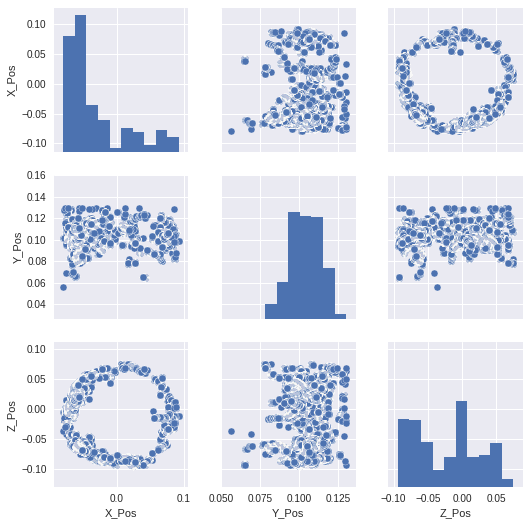

In [14]:
# bivariate example distributions
fig = plt.figure(figsize=(12,12))
sns.pairplot(df[1], vars=['X_Pos', 'Y_Pos', 'Z_Pos'])

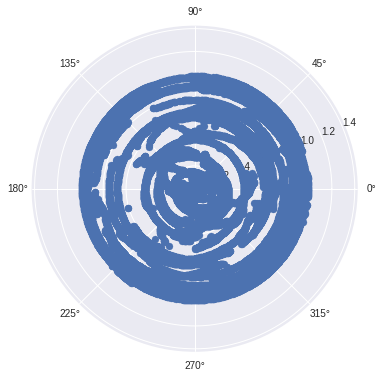

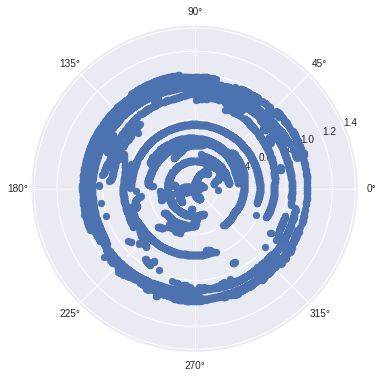

In [15]:
#rotation based on flattened orientation vector

#Rotation of the head for single stimulation event
start_index = 0 
stop_index  = 100000
    

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar = 'true')
c = ax.scatter(df[1].Time_Ori[start_index:stop_index], df[1].Z_Ori[start_index:stop_index])

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar = 'true')
c = ax.scatter(df[1].Time_Ori[start_index:stop_index], df[1].X_Ori[start_index:stop_index])


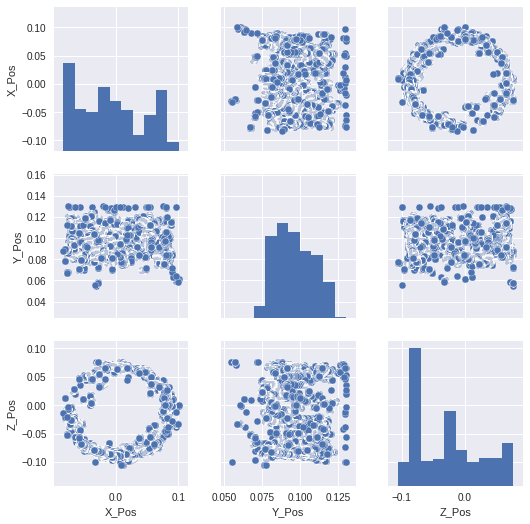

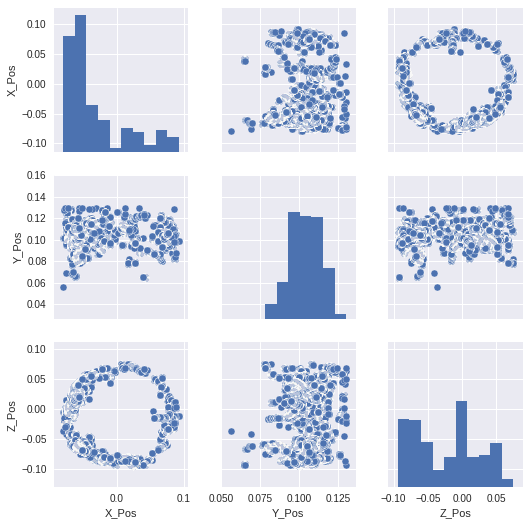

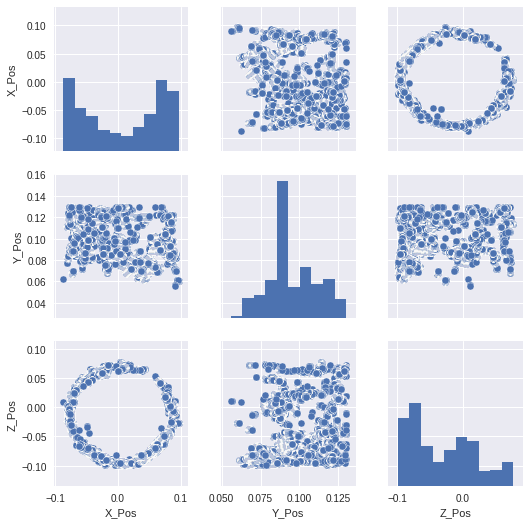

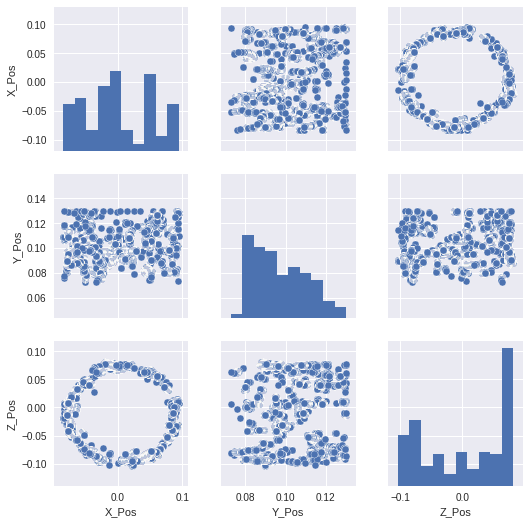

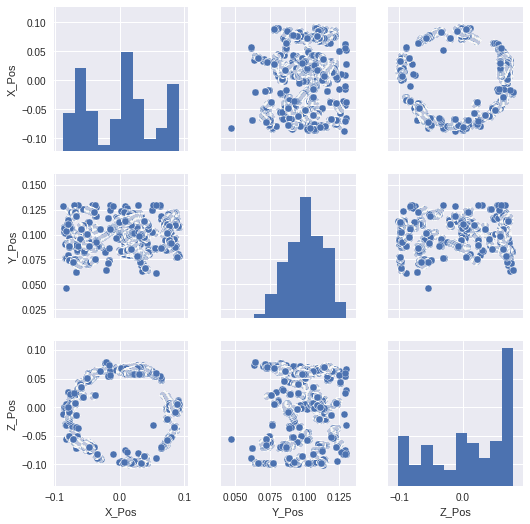

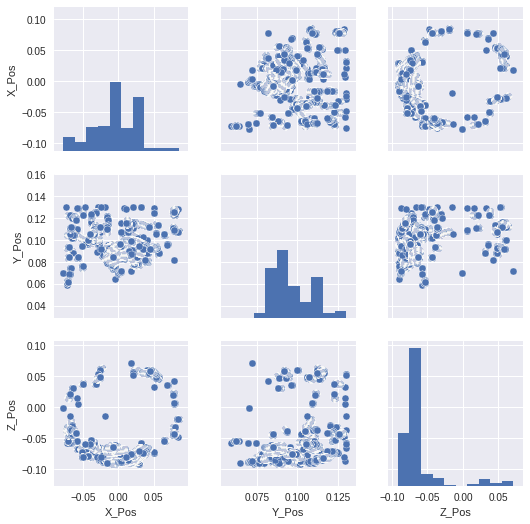

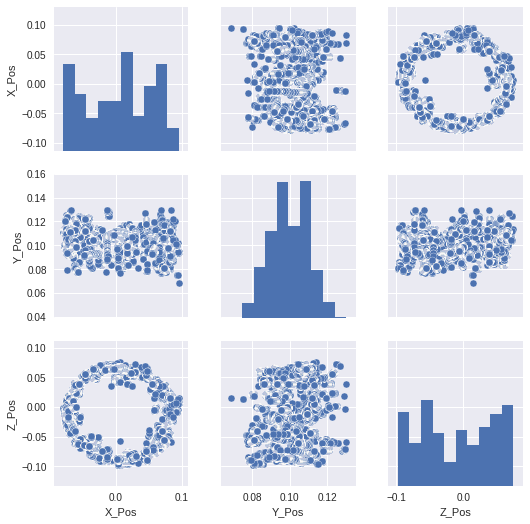

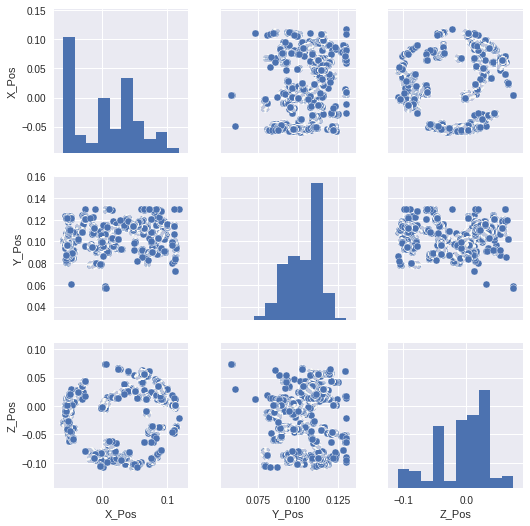

In [16]:
# bivariate multiple distributions distributions
fig = plt.figure(figsize=(12,12))
for i, x in enumerate(fnameClean):
    sns.pairplot(df[i], vars=['X_Pos', 'Y_Pos', 'Z_Pos'])

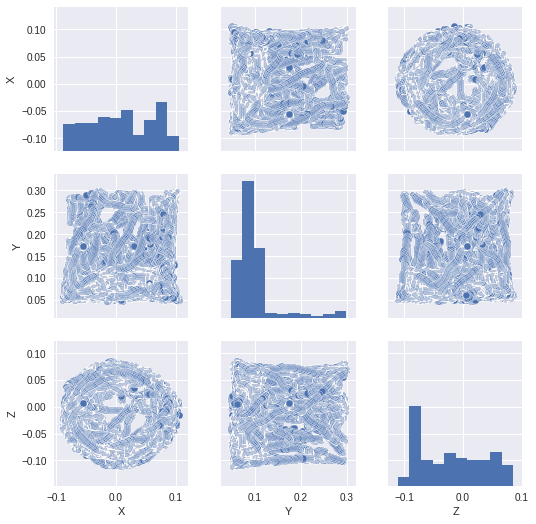

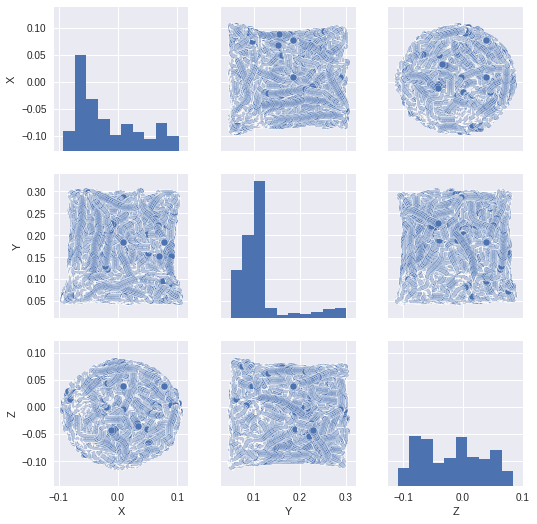

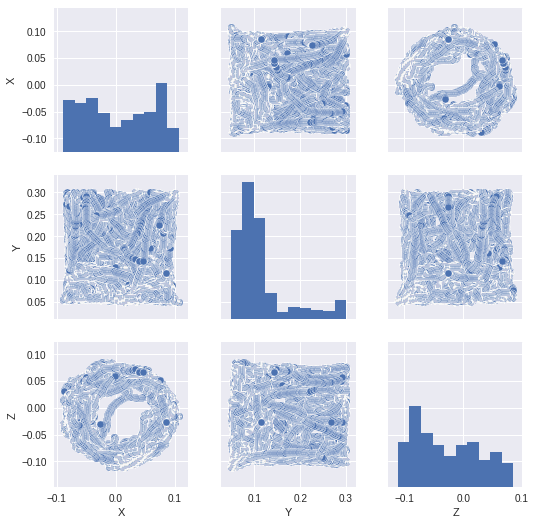

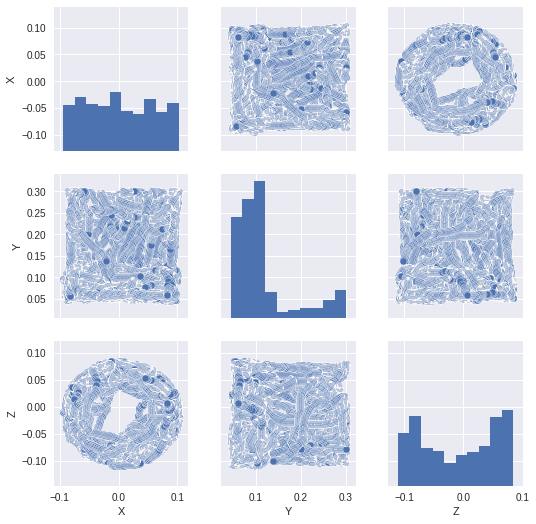

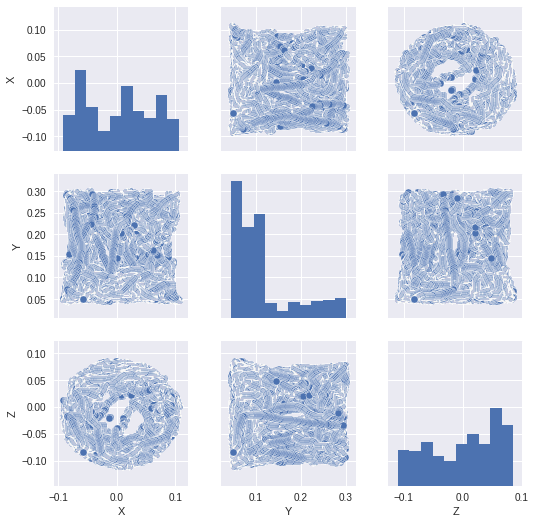

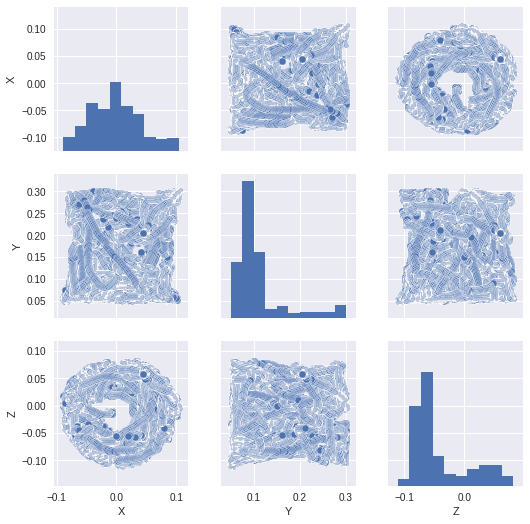

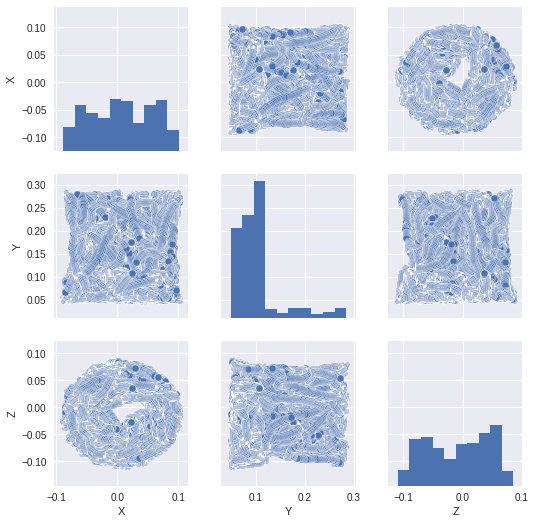

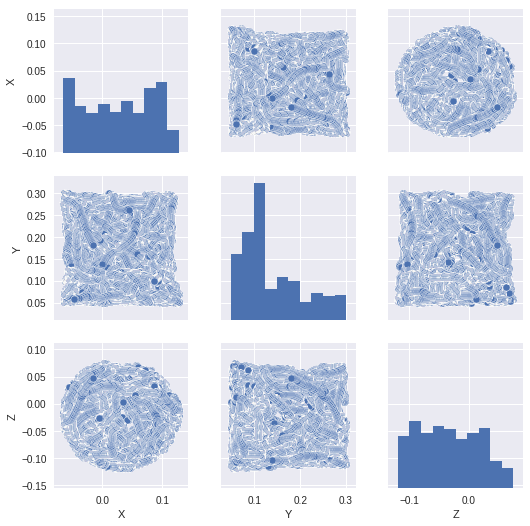

In [17]:
#comparison with non-filter data
dfPos_Raw = {}
fig = plt.figure(figsize=(12,12))

for i, x in enumerate(fnameClean):
    dfPos_Raw[i] = pd.read_hdf(path+fnameClean[i], 'Position')
    sns.pairplot(dfPos_Raw[i], vars=['X', 'Y', 'Z'])

## Comparison of datasets parameters
pre- and post-filetring

In [18]:
sum_fil = 0
for i, x in enumerate(fnameClean):
    #dfPos_Raw[i] = pd.read_hdf(path+fnameClean[i], 'Position')
    sum_fil += len(df[i])
    
#print(sum_fil)
#print(sum_raw)
print('1. filter data size: %f%%' % (sum_fil1*100/sum_raw))
print('2. filter data size: %f%%' % (sum_fil2*100/sum_raw))
print('3. filter  data size: %f%%' % (sum_fil3*100/sum_raw))
print('final filetred data size: %f%%' % (sum_fil*100/sum_raw))


1. filter data size: 81.252504%
2. filter data size: 63.624757%
3. filter  data size: 38.907480%
final filetred data size: 30.287405%
